# The use of bootstrapping in valuation as an example of the development of elements of credit policy for a small bank

Cyrill A. Murashev, 2023-03-07

This article is available in three versions: [English](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Bootstrap/bootstraping_CP.ipynb), [Spanish](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Bootstrap/bootstraping_CP-esp.ipynb) and [Russian](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Bootstrap/bootstraping_CP-nrs.ipynb).

## Abstract

This material is a continuation of a cycle of work on the topic of resampling methods. We discussed the jackknife method in the [previous article](https://github.com/Kirill-Murashev/AI_for_valuers_book/blob/main/Parts-Chapters/Jackknife/jackknife.ipynb). Today we will look at the more popular and universal method of bootstrapping. It would not be an exaggeration to say that bootstrapping is one of the cornerstones of modern data science, along with, for example, linear regression or ROC analysis. This material was developed specifically for appraisers, so we will look at the topic from the point of view of its practical usability in the practice of collateral lending.

Let's imagine a small bank operating in Eastern Europe. Its management has set a goal to develop a system of rules for the bank's credit policy. One of them should solve the task of determining the maximum price of the mortgaged property, which is safe for the financial stability of the bank. It was decided to take into account the modern reality, especially the latest achievements in the world of artificial intelligence, as well as the requirements of [IFRS 13 “Fair Value Measurement”](https://www.ifrs.org/issued-standards/list-of-standards/ifrs-13-fair-value-measurement/). Thus, it was decided to minimize the influence of subjective factors and maximize the influence of scientific methods. Since the capabilities of the small financial institution are rather limited, there is no opportunity to implement the full-scale AI methods based on a real big data. Instead, it is reasonable to implement some local solutions based on machine learning and apply them to the medium-sized sample.

It is very important to understand the following:
1. we are dealing with a sample data, not with the whole market data;
1. our goal is to estimate some parameters of the market, not only for the sample.

There is another fundamental premise that must be understood when analyzing market data. Appraisers almost never know the distribution of a characteristic in market data. Thus, they work with an unknown distribution, which places some limitations on the application of classical statistical approaches based on assumptions related to the shape of the distribution.

In this context, we should apply some special methods that can help us to bring the estimates of the parameters made for the sample closer to the true values that exist in the market under consideration. They must also be free of the shape of the distribution.

Today we will explore the method of bootstrapping in its basic and some just more sophisticated implementations. It allows us to improve almost any estimate made for the sample and reduce its bias relative to the true value that exists in the market, regardless of the distribution of the characteristic in the initial sample.

## Task statement and key inputs

As mentioned above, our training task is to develop some aspects of a bank's credit policy. Imagine a local market for real estate. The bank often makes loans secured by this property. In this case, one of the tasks is to set limits for the maximum possible loan amount, as well as the maximum safe value of the collateral. Both of these conditions are conditioned by the need to limit potential losses. And the second is also conditioned by the low liquidity of atypical objects, including those whose absolute or unit price is too high. In addition, insurance companies usually have their own limits, and they would not accept the risk of an excessive insurance payout, shifting it to the insured in the part of exceeding the limit. Therefore, it is reasonable to set the upper limit of the mortgaged property. In this case, the property with a value lower than the limit would be accepted as collateral for its full value. And a property with a value higher than the limit would be accepted at the limit value. This applies to both total and unit values. In some cases, it would also make sense to limit the price floor.

In order to achieve a balance between financial security and profitability, the best choice is to determine the market values of safe limits. This task requires estimation of certain specific parameters of the whole market. Since we have only a sample, we should apply some special methods that will help us to correct the bias between sample and population estimates. Now we can create a system of rules. 
1. The upper limit of the total value of the property is equal to the expectation plus one standard deviation.
1. The upper limit of the unit value of the property is equal to the expectation plus two standard deviations.

The specific values of the standard deviation coefficients could be shifted one way or the other, depending on a bank's objectives.

Then we will estimate the values of the necessary parameters. We should estimate the true values of the four parameters: total and unit market values, as well as their standard deviations. As mentioned above, we can't get true values directly because we're working with samples. Therefore, we will use the method of bootstrapping, which allows us to reduce the bias of the sample estimates relative to the true values that exist in the population.

## Description of the method

### The General Statements of Bootstrapping

**Bootstrapping** is a random sampling with replacement technique. It belongs to the broader class of resampling methods. This technique can be used to estimate the sampling distribution of almost any statistic.

In practice, when analyzing data, appraisers are almost always faced with the need to estimate the variance and confidence intervals of some measure. It is difficult to make useful inferences based on point estimates alone. Therefore, it is very useful to be able to estimate the confidence intervals of any indicators. Classical statistics tells us that we can, for example, estimate confidence intervals for the mean under certain assumptions. But it does not give a simple answer to the question of what to do if these assumptions are violated. Estimating confidence intervals for the median is a much more complex problem in itself. So we need a universal method that allows us to estimate almost any parameter and obtain its variance and confidence intervals, regardless of any assumptions about the distribution of that parameter.

The method of bootstrapping successfully solves the problem of obtaining values of such indicators regardless of the data distribution. Moreover, it allows you to improve any sample estimates, bringing their values closer to the true values in the population.

Let's imagine that there is some general population that has *N* elements. But we only have a sample of size *n*. If the *N* and *n* are the same, we can just get any parameter directly from the sample. In practice, the *n* is just almost far smaller than the *N*. So, we need to apply some function **'F(X)'** to obtain estimates of some parameter for the sample. In the case where we know the distribution of the parameter in the general population, we can use the obtained point estimate. But more often than not, we do not know this distribution. In this case, the resulting point estimate is not useful enough for us. The fact is that we cannot somehow correlate it with the true value of the parameter for the entire general population. So we need to somehow get not only the estimate, but also its expected distribution in the population. That is, we should get a set of estimates as if we had many samples. But we only have one sample. So we need some kind of resampling. The summary of the above is shown in the figure below.

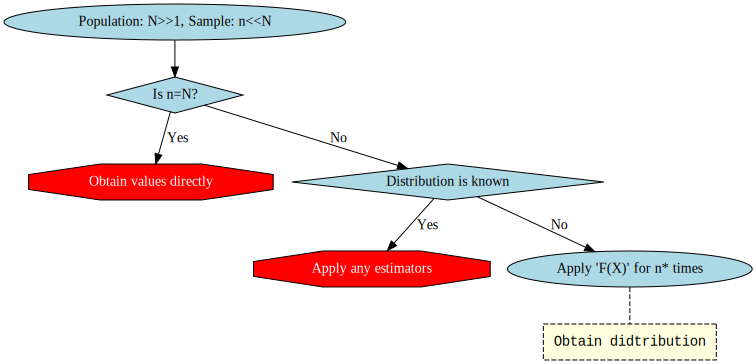

In [2]:
from flowgiston import *
Base = flowgiston_base(fillcolor='lightblue')
class Yes(Base):
    fillcolor = 'Red'
    fontcolor = 'white'
    shape = 'octagon'

class Note(Base):
    fillcolor = 'lightyellow'
    style = 'filled,dashed'
    shape = 'box'
    fontname = 'courier'

chart = FlowgistonChart(Base)

sample = chart.start("Population: N>>1, Sample: n<<N").edge(chart.if_("Is n=N?"))
sample.yes(chart.Yes.node("Obtain values directly"))
distribution = sample.no(chart.if_("Distribution is known"))
distribution.yes(chart.Yes.node("Apply any estimators"))
end = distribution.no(chart.end("Apply 'F(X)' for n* times")).edge(chart.Note.node("Obtain didtribution"), style='dashed', dir='none')
chart

Let's look at an example. We need to find the distribution of the following parameter:
$$\frac{\overline{x}-\mu}{\frac{S}{\sqrt{n}}}.$$

Based on the flowchart above, we are forced to reject direct estimation. Then we can choose between the classical statistical approach and resampling. The first requires that we know the distribution. Or we can make some assumptions about the distribution. For example, we can assume that the estimated characteristic has a normal distribution in the general population. Then our parameter would have the **t-distribution**. But we have no answer to what would happen if our assumptions were wrong.

In valuation practice, we almost always do not know the distribution of a feature in the market and cannot make reliable guesses about it. Bootstrapping can help us in such a case. The idea is as follows. We have only one sample. Therefore, we can only get the point estimate of the parameter. But if we were able to get some number of samples from the general population, we would also be able to get the distribution of the parameter in them. This, in turn, would allow us to obtain the confidence intervals of the parameter, regardless of any assumptions. In practice, we are not able to get new samples without losses in size. But we can simulate new pseudo-samples as if we could get some samples from the population.

If our sample is large enough, its distribution is to some extent a reflection of the distribution in the general population. This fact allows us to make an important step in understanding the concept of bootstrapping, as well as the general concept of resampling. The classical statistical approach relies on a prior assumption about the shape of the distribution in the general population. Resampling methods, on the other hand, assume that the distribution in the general population is approximately the same as the sampling distribution. In a more general sense, we can say that the method involves working with the sample as if it were the general population. We take a sample and assume that it reflects the distribution of the population. Then we apply some resampling techniques. Then we use the function to calculate the statistics we are interested in. As a result, we extend the conclusions drawn from the sample to the entire population. The described technique looks a bit recursive. However, it works very well in practice.

### The technique of bootstrapping

#### Obtain confidence intervals

Let's consider a simple case, the more advanced version of which will be useful for our main task. We have a sample $X[x_{1}\ldots x_{n}]$ and want to find the confidence interval for the mean. Of course, we have no problem calculating the sample mean. However, it's just a single number that relates only to the sample itself. The classical approach tells us that we can get the confidence interval from this value. But only if the distribution is known. In practice, we have no idea about the true distribution in the market. Therefore, it is very likely that the calculated confidence interval will be misleading. Instead, we will assume that the sample is fairly representative and to some extent reflects the true distribution in the population. Next, we will take the following steps.
1. We take our sample and use random sampling with replacement to create a new sample of the same size. This means that one or more observations from the original sample can be repeated any number of times in the new sample.
1. Repeat the previous step at least a thousand times. The more times you repeat this process, the better the result. Thus, the upper limit of repetitions is set only by the computing power.
1. Let's introduce some new notation and label the new sample as $X^{*}$. So we now have a set of $X^{*}$ from $X_{1}^{*}$ to $X_{B}^{*}$.
1. Calculate the statistic of interest for each $X^{*}$. In our case, it will be the mean. This will give us a set of values $\overline{X_{1}^{*}},\ldots,\overline{X_{B}^{*}}$.
1. It is easy to see that we now have the distribution of the statistic of interest. This allows us to work with it as we would with any known distribution. For example, we can set quantiles of interest and calculate the confidence interval, which was our original goal.

The above algorithm allows us to provide an implementation of the **percentile bootstrap**. It is the simplest and most intuitive type of bootstrapping. But it has some limitations. The main one is that this technique can only handle symmetric distributions well. The more sophisticated but also more universal technique is the **basic bootstrap**. This approach uses a slightly different technique. It has the same first two steps. But in the third step, we calculate a different statistic:$\overline{X} - \overline{X_{i}^{*}}$. As a result, we get the distribution of the following statistic:
$$\overline{X} - \overline{X_{i}^{*}}.$$
Its main idea is that we should achieve the following due to a very large number of repeated samples 
$$\mu - \overline{X} \approx \overline{X} - \overline{X^{*}}.$$
Let's label the distribution of $\mu - \overline{X}$ as $\beta$. If we knew alpha, we could get its quantiles, for example $\beta_{0.025}, \beta_{0.975}$. This means that we could estimate the probability of the following:
$$
P\left(\mu-(\overline{x}) \in [\beta_{0.025}, \beta_{0.975}]\right).
$$
Of course, for the known beta, the probability is 0.95. The previous equation can be rewritten as follows:
$$\begin{cases}
\mu-\overline{x} \leq \beta_{0.975}\\
\mu-\overline{x} \geq \beta_{0.025}.
\end{cases}
$$
It gives us the knowledge that
$$
P\left(\mu \in [\beta_{0.025}+\overline{x}, \beta_{0.975}++\overline{x}]\right).
$$
Thus, we obtain the distribution of the population by bootstrap approximation and estimate the confidence intervals.

#### Testing hypotheses

The universality of bootstrapping is that it allows not only to obtain a statistic, but also to test hypotheses. Let us consider an example. Let us have two samples: $X=x_{1},\ldots,x_{n}$ and $Y=y_{1},\ldots,y_{m}$. And we want to test if the expectations of X and Y are equal: $\mu_{X}=\mu_{Y}\ -\ ?$. However, all we can get are the sample means. The well-known t-test can do the job, but it also has a well-known limitation. It is based on the assumption of a normal distribution of the characteristic in both samples. However, our distributions are unknown. Bootstrapping will help us to overcome this limitation. The basic approach is the same as in classical statistics. We construct null and alternative hypotheses. Then we estimate the distribution of the resulting statistic for the case where the null hypothesis is true. But the hypotheses themselves are a bit exotic. The null hypothesis is that the distributions of the *X* and *Y* are equal.
1. Combine the two samples into one, keeping the data about the origin of each observation.
1. Generate new sample of size *m+n* by resampling with replacement.
1. Divide it into two samples by the trait of origin.
1. Calculate $\overline{X_{i}^{*}}$ and $\overline{Y_{j}^{*}}$.
1. Subtract $\overline{Y_{j}^{*}}$ from $\overline{X_{i}^{*}}$.
1. Repeat steps 2 through 5 *k* times *(k>1000)*.
1. Now we have the distribution of the differences between $X^{*}$ and $Y^{*}$.
1. All we need now is to subtract Y from X and find the probability *(p-value)* of such a difference for our distribution obtained in the previous step.
1. Next, we compare the p-value to the $\alpha$ (the most common is 0.05) and make a decision whether to reject the null hypothesis. 

The last two steps are no different from the classical approach to hypothesis testing.

### Types of bootstrapping techniques

There are many ways to bootstrap. Today, we will only look at the three that should be sufficient for an appraiser's first dive into machine learning.

#### Basic bootstrap

##### General concept

The basic bootstrap is a statistical technique for estimating the distribution of a sample statistic, such as the mean or standard deviation, from a single sample of data. The basic bootstrap method involves resampling the original sample with replacement to create numerous simulated samples, calculating the statistic of interest for each simulated sample. And then using the distribution of these simulated statistics to estimate the distribution of the statistic of interest.

Here is a step-by-step description of the basic bootstrap method.
1. Take a random sample of size *n* from the population of interest.
1. Draw numerous random samples of size *n* from the original sample with replacement. This means that for each sample, you randomly select *n* observations from the original sample, and each observation can be selected more than once.
1. For each simulated sample, compute the statistic of interest (e.g., mean or standard deviation).
1. Estimate the distribution of the statistic of interest by the way of calculating the mean, standard deviation, or confidence intervals of the simulated statistics.

The basic bootstrap method is useful when you have a small sample size or when you cannot assume that the population is normally distributed. It can be used to estimate the uncertainty associated with a sample statistic, to compare different groups or conditions, or to test hypotheses about the population.

It is important to note that the basic bootstrap method assumes that the original sample is representative of the population of interest and that the sample observations are independent and identically distributed. If these assumptions are not met, the results of the bootstrap may not be accurate.

##### Advantages and disadvatages

**Advantages** of basic bootstrap.
1. Non-parametric: The basic bootstrap method does not make any assumptions about the distribution of the population, and therefore it is a non-parametric method. This makes it a useful tool for analyzing data that may not follow a normal distribution.
1. Flexibility: The basic bootstrap method can be applied to a wide range of statistics, such as means, variances, and proportions. This makes it a versatile tool for many types of research questions.
1. Sample size: The basic bootstrap method is particularly useful when the sample size is small. By generating multiple samples from the original data, the method can provide more accurate estimates of the population parameters.
1. Confidence intervals: The basic bootstrap method can be used to estimate confidence intervals for the population parameters, which can help to quantify the uncertainty associated with the estimates.

**Disadvantages** of basic bootstrap.
1. Computationally intensive: The basic bootstrap method requires generating a numerous resamples, which can be computationally intensive and time-consuming, especially for large datasets.
1. Bias: The basic bootstrap method can be biased if the original sample is not representative of the population. This can lead to inaccurate estimates of the population parameters.
1. Data dependence: The basic bootstrap method assumes that the observations in the original sample are independent and identically distributed. If this assumption is not met, the results of the bootstrap may not be accurate.
1. Accuracy: The accuracy of the basic bootstrap method depends on the number of resamples generated. If the number of resamples is too small, the results may not be reliable. However, generating a numerous resamples can be computationally intensive, as mentioned above.

#### Smoothed bootstrap

##### General concept

One issue with the basic bootstrap is that it can produce estimates that are too variable or unstable, particularly when the sample size is small or the distribution of the data is highly skewed or has heavy tails. The smoothed bootstrap is a modification of the basic bootstrap that addresses this issue by adding a smoothing step to the resampling process.

In the smoothed bootstrap, rather than sampling directly from the original data set, we first fit a probability density function (PDF) to the data using a kernel density estimator (KDE) or a similar method. We then sample from this PDF to generate the bootstrap samples, rather than directly sampling from the original data set. This has the effect of “smoothing” the distribution and can help to reduce the variability of the bootstrap estimates.

One common approach to implementing the smoothed bootstrap is to use the resampling algorithm as follows.
1. Fit a probability density function to the original data using a kernel density estimator or a similar method.
1. Generate numerous bootstrap samples by sampling from the PDF rather than directly from the data.
1. Calculate the statistic of interest for each of these bootstrap samples.
1. Compute the mean, median, CIs, etc. of the resulting bootstrap estimates to obtain the final estimate of the statistic.

The smoothing step can be adjusted to balance the bias-variance tradeoff in the estimation procedure. A higher degree of smoothing leads to a more biased estimate but with lower variance, while a lower degree of smoothing leads to a less biased estimate but with higher variance. The choice of smoothing parameter depends on the specific application and the characteristics of the data.

##### Advantages and disadvatages

**Advantages** of smoothed Bootstrap.
1. Reduced variability: The main advantage of the smoothed bootstrap is that it can reduce the variability of the bootstrap estimates compared to the basic bootstrap. This is particularly useful when the sample size is small or the distribution of the data is highly skewed or has heavy tails.
1. More accurate estimates: The smoothing step in the smoothed bootstrap can also help to produce more accurate estimates of the underlying distribution of the data, especially in cases where the true distribution is unknown or difficult to estimate.
1. Flexibility: The smoothed bootstrap is flexible and can be adapted to different types of data and statistical models. It can also be used to estimate the distribution of more complex statistics, such as quantiles or regression coefficients.

**Disadvantages** of smoothed Bootstrap.
1. Bias: The smoothing step in the smoothed bootstrap can introduce bias into the estimates, especially if the smoothing parameter is set too high. This bias can be difficult to quantify and correct for.
1. Complexity: The smoothed bootstrap can be more computationally intensive than the basic bootstrap, especially if the smoothing step involves fitting a complex model or estimating numerous parameters.
1. Dependence on the smoothing parameter: The choice of smoothing parameter in the smoothed bootstrap can have a significant impact on the quality of the estimates. Finding the optimal smoothing parameter can be challenging and may require additional tuning or validation steps.
1. Possible loss of information: The smoothing step in the smoothed bootstrap can also result in a loss of information about the underlying distribution of the data. This can make it difficult to draw inferences about the true distribution or to detect features such as outliers or bimodality.

#### Bayesian bootstrap

##### General concept

The Bayesian bootstrap is a resampling method used in Bayesian inference that can be used to estimate the posterior distribution of a parameter or model. Like other bootstrap methods, the Bayesian bootstrap involves generating numerous samples from the data, but it does so in a Bayesian context.

In the Bayesian bootstrap, we assume that the data come from some unknown distribution that can be described by a prior distribution and a likelihood function. We then simulate new data sets by resampling from the original data set, but instead of just resampling the data with replacement, we also resample the prior distribution.

More specifically, the Bayesian bootstrap algorithm can be summarized as follows:

1. Define a prior distribution for the unknown parameter(s) or model.
1. Calculate the likelihood function of the data given the parameter(s) or model.
1. Sample a new prior distribution by resampling from the original prior distribution.
1. Sample a new data set by resampling from the original data set.
1. Calculate the posterior distribution of the parameter(s) or model using the new prior distribution and the likelihood function based on the new data set.
1. Repeat steps 3-5 to generate numerous simulated posterior distributions.

The resulting posterior distributions can then be used to estimate the mean, variance, and other characteristics of the true posterior distribution, as well as to make probabilistic statements about the parameter(s) or model.

One advantage of the Bayesian bootstrap is that it can be used with a wide range of prior distributions and likelihood functions, making it a versatile tool for Bayesian inference. It can also be used to estimate the posterior distribution of complex models that cannot be analytically solved, and it does not require any assumptions about the shape of the underlying distribution or the presence of outliers. However, like other resampling methods, the Bayesian bootstrap can be computationally intensive and may require numerous simulations to produce accurate estimates of the posterior distribution.

##### Advantages and disadvatages

**Advantages** of Bayesian Bootstrap.
1. Flexibility: The Bayesian bootstrap is a flexible method that can be applied to a wide range of statistical models and priors. This makes it useful in many situations where other methods may not be applicable.
1. No assumptions about the underlying distribution: Unlike some other methods, the Bayesian bootstrap does not require any assumptions about the shape of the underlying distribution or the presence of outliers.
1. Provides a full posterior distribution: The Bayesian bootstrap provides a full posterior distribution of the unknown parameter(s) or model, rather than just a point estimate. This allows for a more complete understanding of the uncertainty associated with the estimate.
1. Handles complex models: The Bayesian bootstrap can be used to estimate the posterior distribution of complex models that cannot be analytically solved.

**Disadvantages** of Bayesian Bootstrap.
1. Computationally intensive: The Bayesian bootstrap can be computationally intensive, especially for large data sets or complex models. This can make it impractical in some situations where other methods may be faster.
1. May be sensitive to the choice of prior: The Bayesian bootstrap relies on the choice of prior distribution. The choice of prior can affect the results of the analysis, so it is important to carefully choose a prior that is appropriate for the problem being studied.
1. May not perform well in small sample sizes: The Bayesian bootstrap can be sensitive to small sample sizes, and may not perform as well as other methods in situations where the sample size is very small.
1. Requires some understanding of Bayesian inference: The Bayesian bootstrap is a method within Bayesian inference and requires some understanding of Bayesian principles and concepts to use effectively. This may limit its use in some fields or applications where users are not familiar with Bayesian methods.

## Practical implementation

### Common issues

Let's return to our learning task and compute the true values in the market to help the bank design its credit policy. We will use the real data set with 2355 observations in one of the markets. Today we have the two columns of interest: 'price' and 'price_m'. The first one contains data on the prices of the real estate objects themselves, and the second one on their prices per square meter. In the first step, we perform some technical steps and compute the sample estimates.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from scipy.stats import norm
from scipy.stats import scoreatpercentile

# limitation of digits
# pd.set_option('display.float_format', lambda x: f'{x:.5f}')
# np.set_printoptions(precision=5)

In [3]:
# create function for easy calculation of sample standard deviation
def appr_sam_std(a, ddof = 1):
    return np.std(a, ddof = ddof)

In [4]:
# import data
data = pd.read_csv("ds.csv", index_col=False)

# calculate statistics for the "general population"
tp_sample_mean   = data['price'].mean()
up_sample_mean   = data['price_m'].mean()
tp_sample_std    = data['price'].std()
up_sample_std    = data['price_m'].std()
formatted_tp_sample_mean = '{:.2f}'.format(tp_sample_mean)
formatted_up_sample_mean = '{:.2f}'.format(up_sample_mean)
formatted_tp_sample_std = '{:.2f}'.format(tp_sample_std)
formatted_up_sample_std = '{:.2f}'.format(up_sample_std)
print("The sample mean price is", formatted_tp_sample_mean)
print("The sample mean unit price is", formatted_up_sample_mean)
print("The sample standard deviation of price is", formatted_tp_sample_std)
print("The sample standard deviation of unit price is", formatted_up_sample_std)

The sample mean price is 23372356.69
The sample mean unit price is 361554.02
The sample standard deviation of price is 16061866.51
The sample standard deviation of unit price is 95947.20


Now we can move on to bootstrapping. There are some library functions for this, but today we will create our own functions to better understand the nature of the techniques. We will create and implement functions for the following types of bootstrapping:
1. basic bootstrap;
1. smoothed bootstrap;
1. Bayesian bootstrap.

There is no single “best” type of bootstrapping, as the choice of which method to use depends on the specific problem at hand and the goals of the analysis. The basic bootstrap and the percentile bootstrap are two of the most commonly used methods, but there are other variants of bootstrapping, such as the bias-corrected and accelerated (BCa) bootstrap and the studentized bootstrap.

The basic bootstrap is the simplest and most straightforward method, as it involves repeatedly sampling from the original data with replacement and calculating the statistic of interest on each bootstrap sample. This method is generally suitable for estimating the sampling distribution of simple statistics such as the mean or variance, and is relatively easy to implement.

The percentile bootstrap is a more sophisticated method that involves calculating the confidence interval of the statistic of interest using the empirical percentiles of the bootstrap distribution. This method is mostly preferred when the sampling distribution of the statistic is non-normal or the sample size is small, as it provides more accurate confidence intervals and is less sensitive to the underlying distribution of the data.

The BCa bootstrap is a variant of the percentile bootstrap that adjusts for bias and skewness in the bootstrap distribution. It is mostly more accurate than the basic and percentile bootstrap for small samples or when the underlying distribution is highly skewed. However, it can be more computationally intensive and requires more advanced statistical knowledge to implement.

The studentized bootstrap is a method that involves standardizing the statistic of interest by the way of using its estimated standard error, and then resampling from a t-distribution with degrees of freedom equal to the sample size minus one. This method is generally preferred when the statistic of interest is a ratio or difference of two estimates, or when the distribution of the statistic is highly skewed or heavy-tailed.

In summary, the choice of which type of bootstrapping to use depends on the specific problem at hand and the goals of the analysis, as well as the computational resources available and the statistical expertise of the analyst. It is often a good idea to compare the results of multiple bootstrapping methods to ensure that the conclusions are robust and not overly sensitive to the choice of method.

### Basic bootstrap

The code below defines a function 'appr_basic_bootstrap' that performs a basic bootstrap on a data set to compute a statistic and its confidence intervals using the asymptotic method.

The function takes in five arguments:
1. *data*: an array-like input dataset;
1. *num_samples*: the number of bootstrap samples to generate;
1. *sample_size*: the size of each bootstrap sample, defaults to the size of the input dataset;
1. *stat_func*: the statistic to calculate on each bootstrap sample, defaults to the mean;
1. *ci*: the confidence interval to calculate, defaults to 95%.

The function first checks if sample_size is None, if so, it sets sample_size to the length of data. Next, it calculates the original_statistic by applying the stat_func on the input data. Then, it generates num_samples bootstrap samples of size sample_size by randomly choosing elements from data with replacement using np.random.choice.

It calculates the stat_func for each bootstrap sample using np.apply_along_axis and stores the resulting values in bootstrap_statistics. Next, it calculates the mean of all the stat_func values from the bootstrap samples to get the bootstrap_statistic.

Finally, it calculates the ci_lower and ci_upper values for the confidence interval using scipy.stats.scoreatpercentile with alpha values of (100 - ci) / 2 and 100 - (100 - ci) / 2, respectively.

The function returns a tuple containing the 'bootstrap_statistic', 'ci_lower', and 'ci_upper'.

In [5]:
def appr_basic_bootstrap(data, stat_func=np.mean, num_samples=2000, sample_size=None, ci=95):
    """
    Perform basic bootstrap on a dataset to calculate a statistic and its confidence intervals.

    Parameters:
        data (array-like): The input dataset.
        num_samples (int): The number of bootstrap samples to generate.
        sample_size (int): The size of each bootstrap sample. Defaults to the size of the input dataset.
        stat_func (function): The statistic to calculate on each bootstrap sample. Defaults to the mean.
        ci (int): The confidence interval to calculate. Defaults to 95%.

    Returns:
        A tuple containing the calculated statistic and its confidence interval.
    """
    if sample_size is None:
        sample_size = len(data)

        
    # Calculate the statistic on the original dataset
    original_statistic = stat_func(data)    
        
    # Generate bootstrap samples
    bootstrap_samples = np.random.choice(data, size=(num_samples, sample_size), replace=True)

    # Calculate the statistic on each bootstrap sample
    bootstrap_statistics = np.apply_along_axis(stat_func, axis=1, arr=bootstrap_samples)
    
    # Calculate the mean of all statistic's values
    bootstrap_statistic = np.mean(bootstrap_statistics)
    
    # Calculate the confidence interval
    alpha = (100 - ci) / 2
    ci_lower = scoreatpercentile(bootstrap_statistics, alpha)
    ci_upper = scoreatpercentile(bootstrap_statistics, 100 - alpha)

    return bootstrap_statistic, ci_lower, ci_upper

Now let's apply it to our data.

In [6]:
# apply the 'appr_basic_bootstrap' function to data
tp_basic_bootstrap_mean = appr_basic_bootstrap(data['price'])
tp_basic_bootstrap_std  = appr_basic_bootstrap(data['price'], stat_func = appr_sam_std)
up_basic_bootstrap_mean = appr_basic_bootstrap(data['price_m'])
up_basic_bootstrap_std  = appr_basic_bootstrap(data['price_m'], stat_func = appr_sam_std)

# extract single balues from tuple
tp_basb_mean, tp_basb_mean_lowCI, tp_basb_mean_upperCI = tp_basic_bootstrap_mean
tp_basb_std, tp_basb_std_lowCI, tp_mean_basb_upperCI = tp_basic_bootstrap_std
up_basb_mean, up_basb_mean_lowCI, up_basb_mean_upperCI = up_basic_bootstrap_mean
up_basb_std, up_basb_std_lowCI, up_mean_basb_upperCI = up_basic_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the basic bootstrap is {tp_basb_mean:.2f} \
with 95% confidence interval [{tp_basb_mean_lowCI:.2f}, {tp_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the basic bootstrap is {tp_basb_std:.2f} \
with 95% confidence interval [{tp_basb_std_lowCI:.2f}, {tp_mean_basb_upperCI:.2f}].')
print(f'The mean unit price obtained by the basic bootstrap is {up_basb_mean:.2f} \
with 95% confidence interval [{up_basb_mean_lowCI:.2f}, {up_basb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the basic bootstrap is {up_basb_std:.2f} \
with 95% confidence interval [{up_basb_std_lowCI:.2f}, {up_mean_basb_upperCI:.2f}].')

The mean price obtained by the basic bootstrap is 23370941.70 with 95% confidence interval [22727684.71, 24033931.00].
The standard deviation of the price obtained by the basic bootstrap is 16020188.92 with 95% confidence interval [14191560.87, 18008702.41].
The mean unit price obtained by the basic bootstrap is 361566.09 with 95% confidence interval [357732.73, 365501.65].
The standard deviation of the unit price obtained by the basic bootstrap is 95885.97 with 95% confidence interval [91171.64, 100680.84].


### Smoothed bootstrap

We define the **smoothed_bootstrap function**, which takes as input the data, the statistic function of interest, the desired level of confidence interval, and the number of bootstrap samples to generate. The function returns the smoothed bootstrap estimate of the statistic and the lower and upper bounds of the confidence interval.

In [29]:
def appr_smoothed_bootstrap(data, statistic_func, alpha=0.05, n_bs_samples=2000):
    """
    Computes the smoothed bootstrap estimate and confidence intervals for a given statistic.
    
    Args:
    - data (array-like): the data from which to compute the statistic and confidence intervals
    - statistic_func (function): the function to compute the statistic of interest
    - alpha (float): the desired level of confidence interval (default 0.05)
    - n_bs_samples (int): the number of bootstrap samples to generate (default 1000)
    
    Returns:
    - bs_statistic (float): the smoothed bootstrap estimate of the statistic
    - ci_low (float): the lower bound of the confidence interval
    - ci_high (float): the upper bound of the confidence interval
    """
    
    # Compute the observed statistic
    obs_statistic = statistic_func(data)
    
    # Generate the bootstrap samples
    bs_samples = np.random.choice(data, size=(len(data), n_bs_samples))
    
    # Compute the bootstrap statistics
    bs_statistics = np.apply_along_axis(statistic_func, axis=0, arr=bs_samples)
    
    # Compute the standard deviation of the bootstrap statistics
    bs_std = np.std(bs_statistics)
    
    # Compute the smoothed bootstrap weights
    bs_weights = norm.pdf(bs_statistics - obs_statistic, scale=bs_std)
    
    # Compute the smoothed bootstrap estimate of the statistic
    bs_statistic = np.average(bs_statistics, weights=bs_weights)
    
    # Compute the confidence intervals
    bs_statistics_sorted = np.sort(bs_statistics)
    ci_low = bs_statistics_sorted[int(np.floor((alpha/2) * n_bs_samples))]
    ci_high = bs_statistics_sorted[int(np.ceil((1 - alpha/2) * n_bs_samples))]
    
    return bs_statistic, ci_low, ci_high


Applying to the data.

In [35]:
# apply the 'appr_smoothed_bootstrap' function to data
tp_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price'], statistic_func = np.mean)
tp_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price'], statistic_func = appr_sam_std)
up_smoothed_bootstrap_mean = appr_smoothed_bootstrap(data['price_m'], statistic_func = np.mean)
up_smoothed_bootstrap_std  = appr_smoothed_bootstrap(data['price_m'], statistic_func = appr_sam_std)

# extract single balues from tuple
tp_smob_mean, tp_smob_mean_lowCI, tp_smob_mean_upperCI = tp_smoothed_bootstrap_mean
tp_smob_std, tp_smob_std_lowCI, tp_mean_smob_upperCI = tp_smoothed_bootstrap_std
up_smob_mean, up_smob_mean_lowCI, up_smob_mean_upperCI = up_smoothed_bootstrap_mean
up_smob_std, up_smob_std_lowCI, up_mean_smob_upperCI = up_smoothed_bootstrap_std

# output the result to the user
print(f'The mean price obtained by the smoothed bootstrap is {tp_smob_mean:.2f} \
with 95% confidence interval [{tp_smob_mean_lowCI:.2f}, {tp_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the smoothed bootstrap is {tp_smob_std:.2f} \
with 95% confidence interval [{tp_smob_std_lowCI:.2f}, {tp_mean_smob_upperCI:.2f}].')
print(f'The mean unit price obtained by the smoothed bootstrap is {up_smob_mean:.2f} \
with 95% confidence interval [{up_smob_mean_lowCI:.2f}, {up_smob_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the smoothed bootstrap is {up_smob_std:.2f} \
with 95% confidence interval [{up_smob_std_lowCI:.2f}, {up_mean_smob_upperCI:.2f}].')

The mean price obtained by the smoothed bootstrap is 23376253.48 with 95% confidence interval [22768577.49, 23979150.74].
The standard deviation of the price obtained by the smoothed bootstrap is 16001329.71 with 95% confidence interval [14269520.65, 17909150.10].
The mean unit price obtained by the smoothed bootstrap is 361538.07 with 95% confidence interval [357495.87, 365667.21].
The standard deviation of the unit price obtained by the smoothed bootstrap is 95940.75 with 95% confidence interval [91305.76, 100445.92].


### Bayesian bootstrap

The function below takes in six required arguments:
1. *X*, which is the array-like dataset that you want to resample;
1. *stat_func*, which is the function that you want to apply to each resampled dataset to compute the desired statistic (default is np.mean);
1. *num_samples*, which is the number of bootstrap samples to generate (default is 2000);
1. *alpha*, which is the significance level for the credible interval (default is 0.05);
1. *low_mem* set the way of generating the weights (default is False);
1. *resample_size* specifies the size of resampled sample (default is None).

The function first computes the empirical distribution function (EDF) of the data, which is used to generate bootstrap samples from the Bayesian bootstrap. It then applies the statistic function to each bootstrap sample, and computes the Bayesian bootstrap estimate of the statistic by taking the mean of the bootstrap statistics. Finally, it computes the (1-alpha) credible interval by finding the appropriate percentiles of the bootstrap statistics. This function is just a small extension of the [bayesian_bootstrap function](https://github.com/lmc2179/bayesian_bootstrap) by [Louis Cialdella](https://github.com/lmc2179).

In [36]:
def appr_bayesian_bootstrap(X, statistic=np.mean, n_replications=2000, resample_size=None, low_mem=False, alpha=0.05):
    """Simulate the posterior distribution of the given statistic.

    Parameter X: The observed data (array like)

    Parameter statistic: A function of the data to use in simulation (Function mapping array-like to number)

    Parameter n_replications: The number of bootstrap replications to perform (positive integer)

    Parameter resample_size: The size of the dataset in each replication
    
    Parameter low_mem(bool): Generate the weights for each iteration lazily instead of in a single batch. Will use
    less memory, but will run slower as a result.

    Returns: Statistoc for the samples from the posterior
    """
    
    if resample_size is None:
        resample_size = len(X)
    
    if isinstance(X, list):
        X = np.array(X)
    samples = []
    if low_mem:
        weights = (np.random.dirichlet([1] * len(X)) for _ in range(n_replications))
    else:
        weights = np.random.dirichlet([1] * len(X), n_replications)
    for w in weights:
        sample_index = np.random.choice(range(len(X)), p=w, size=resample_size)
        resample_X = X[sample_index]
        s = statistic(resample_X)
        samples.append(s)
        
    samples_sorted = sorted(samples)
    window_size = int(len(samples) - round(len(samples)*alpha))
    smallest_window = (None, None)
    smallest_window_length = float('inf')
    for i in range(len(samples_sorted) - window_size):
        window = samples_sorted[i+window_size-1], samples_sorted[i]
        window_length = samples_sorted[i+window_size-1] - samples_sorted[i]
        if window_length < smallest_window_length:
            smallest_window_length = window_length
            smallest_window = window
            
    posterior_statistic = np.mean(samples)         
            
    return posterior_statistic, smallest_window[1], smallest_window[0]

Applying to data.

In [38]:
# apply the 'appr_bayesian_bootstrap' function to data
tp_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price'])
tp_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price'], statistic = np.std)
up_bayesian_bootstrap_mean = appr_bayesian_bootstrap(data['price_m'])
up_bayesian_bootstrap_std  = appr_bayesian_bootstrap(data['price_m'], statistic = np.std)

# extract single balues from tuple
tp_bayb_mean, tp_bayb_mean_lowCI, tp_bayb_mean_upperCI = tp_bayesian_bootstrap_mean
tp_bayb_std, tp_bayb_std_lowCI, tp_mean_bayb_upperCI = tp_bayesian_bootstrap_std
up_bayb_mean, up_bayb_mean_lowCI, up_bayb_mean_upperCI = up_bayesian_bootstrap_mean
up_bayb_std, up_bayb_std_lowCI, up_mean_bayb_upperCI = up_bayesian_bootstrap_std


# output the result to the user
print(f'The mean price obtained by the Bayesian bootstrap is {tp_bayb_mean:.2f} \
with 95% confidence interval [{tp_bayb_mean_lowCI:.2f}, {tp_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the price obtained by the Bayesian bootstrap is {tp_bayb_std:.2f} \
with 95% confidence interval [{tp_bayb_std_lowCI:.2f}, {tp_mean_bayb_upperCI:.2f}].')
print(f'The mean unit price obtained by the Bayesian bootstrap is {up_bayb_mean:.2f} \
with 95% confidence interval [{up_bayb_mean_lowCI:.2f}, {up_bayb_mean_upperCI:.2f}].')
print(f'The standard deviation of the unit price obtained by the Bayesian bootstrap is {up_bayb_std:.2f} \
with 95% confidence interval [{up_bayb_std_lowCI:.2f}, {up_mean_bayb_upperCI:.2f}].')

The mean price obtained by the Bayesian bootstrap is 23373192.97 with 95% confidence interval [22497282.38, 24304543.52].
The standard deviation of the price obtained by the Bayesian bootstrap is 16014052.16 with 95% confidence interval [13464056.97, 18795443.99].
The mean unit price obtained by the Bayesian bootstrap is 361545.02 with 95% confidence interval [356060.67, 366479.47].
The standard deviation of the unit price obtained by the Bayesian bootstrap is 95910.03 with 95% confidence interval [89534.47, 103327.87].


### Application of the results to the development of elements of a credit policy

All three techniques gave us similar results. So we can use any of them without hesitation. Today, we'll use the results of Bayesian bootstrapping. The posterior mean and standard deviation of the price are 23373192.97 and 16014052.16, respectively. The posterior mean and standard deviation of the unit price are 361545.02 and 95910.03, respectively. Thus, we can set the following rules of limits for the collateral property.

||Minimum limit | Maximum limit | Mean| STD|
|:-|:-|:-|:-|:-|
|Price|**6,483,230.22**|**38,511,334.54**|23,373,192.97|16,014,052.16|
|Unit price|**169,724.96**|**553,365,08**|361,545.02|95,910.03|

The use of such limits can protect a bank from accepting atypical or illiquid collateral.

## Summary

Today, we learned how to overcome the two basic problems that appraisers face every day:
1. the problem of small samples, which are much smaller than the entire market;
2. the problem of unknown distribution.

The bootstrapping easily solves both of these problems. The use of bootstrapping techniques can significantly improve the quality of market data quality. In a sense, it can be said that it is reasonable to use it whenever the appraiser has at least 20 or 30 observations. 
To discuss this or any other topic related to machine learning in valuation, You are welcome to join my [Facebook community](https://www.facebook.com/groups/1977067932456703) as well as to my [Telegram channel](https://t.me/AIinValuation).